In [1]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

## Wczytanie zbioru danych
Poniższy kod przygotowuje zbiór danych do przeprowadzenia treningu. Zostały przygotowane dwa scenariusze:

- A2D2
- Cityscapes

Odpowiedni zbiór wystarczy odkomentować w celu przeprowadzenia na nim treningu.

In [ ]:
from transforms import *
from utils.encoding import ClassMapper

from torchvision.datasets import Cityscapes
from datasets import A2D2Dataset

a2d2_root = ".\\data\\a2d2\\"
cityscapes_root = ".\\data\\cityscapes"

#A2D2

# from torch.utils.data import Subset
# import numpy as np

# mapper = ClassMapper(
#     dataset_class=A2D2Dataset,
#     train_transforms=train_transforms,
#     val_transforms=val_transforms,
#     infer_transforms=test_transforms,
#     reduced_subset=True
#     )

# train_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='train',
#     transforms=mapper.wrap_train
    
# )

# val_dataset_full = A2D2Dataset(
#     root=a2d2_root,
#     split='val',
#     transforms=mapper.wrap_val
# )

# step = 5  # bierz co 5-tą klatkę
# val_idx = np.arange(0, len(val_dataset_full), step).tolist()
# val_dataset = Subset(val_dataset_full, val_idx)

# Cityscapes

mapper = ClassMapper(
    dataset_class=Cityscapes,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    infer_transforms=test_transforms,
    reduced_subset=True
    )

train_dataset = Cityscapes(
    root=cityscapes_root,
    split='train',
    target_type="semantic",
    transforms=mapper.wrap_train
)

val_dataset = Cityscapes(
    root=cityscapes_root,
    split='val',
    target_type="semantic",
    transforms=mapper.wrap_val
)

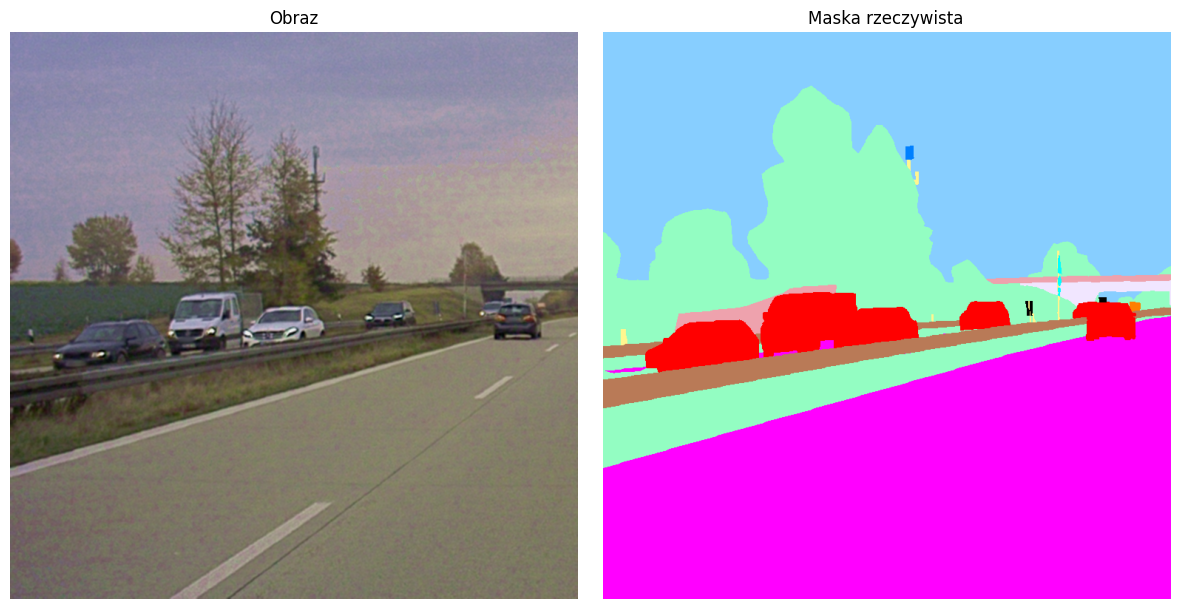

In [3]:
from utils.image import *

image, mask = train_dataset[5]

display_image_and_mask(image=image, mask_true=mask, mapper=mapper)

In [4]:
# Wyświetlanie widocznych na obrazie masek

classes = np.unique(mask)
names = {
    f'{mapper.mapping[int(cid)][1]}'
    for cid in classes
    if int(cid) in mapper.mapping
}
print("\n".join(names))

Road blocks
Grid structure
Buildings
Nature object
Poles
Traffic sign 1
Sky
RD normal street
Traffic signal 1
Car 1
Truck 1
Unlabeled


In [5]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=12, 
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    persistent_workers=True,
    drop_last=True
)

## Trening
Poniższy skrypt inicjalizuje model oraz rozpoczyna jego trening przy zadanych wartościach hiperparametrów.

In [6]:
import os
import segmentation_models_pytorch as smp
import torch.nn as nn

from training.setup_training import *
from training.model import WeightedLoss

# backbones = [
#     smp.DeepLabV3, smp.DeepLabV3Plus, smp.Linknet, smp.Segformer, smp.Unet, 
#     smp.UnetPlusPlus, smp.FPN, smp.PAN, smp.UPerNet, smp.MAnet, smp.PSPNet
# ]

# encoders = [
#     'resnet34', 'resnext50_32x4d', 'se_resnext50_32x4d', 'efficientnet-b4', 
#     'mit_b2', 'mobileone_s4', 'resnet101', 'resnext101_32x8d' 
# ]

# backbones = [
#     smp.DeepLabV3Plus, smp.Linknet, smp.Segformer, smp.PAN
#     ]

# losses = [
#     {
#         'dice': WeightedLoss(smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, ignore_index=255), 1)
#     },
#     {
#         'dice': WeightedLoss(smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, ignore_index=255), 0.8), 
#         'focal': WeightedLoss(smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE, alpha=0.25, gamma=2.0, ignore_index=255), 0.2)
#     },
#     {
#         'dice': WeightedLoss(smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, ignore_index=255), 0.5), 
#         'focal': WeightedLoss(smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE, alpha=0.25, gamma=2.0, ignore_index=255), 0.5)
#     },
#     {
#         'BCE': WeightedLoss(smp.losses.SoftCrossEntropyLoss(ignore_index=255, smooth_factor=0.0), 0.5),
#         'dice': WeightedLoss(smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, ignore_index=255), 0.5)
#     },
#     {
#         'lovasz': WeightedLoss(smp.losses.LovaszLoss(smp.losses.MULTICLASS_MODE, ignore_index=255), 0.5),
#         'BCE': WeightedLoss(smp.losses.SoftCrossEntropyLoss(ignore_index=255, smooth_factor=0.0), 0.5),
#     },
#     {
#         'tversky': WeightedLoss(smp.losses.TverskyLoss(smp.losses.MULTICLASS_MODE, gamma=1.0, ignore_index=255), 1)
#     },
#     {
#         'focal': WeightedLoss(smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE, alpha=0.25, gamma=2.0, ignore_index=255), 0.5),
#         'tversky': WeightedLoss(smp.losses.TverskyLoss(smp.losses.MULTICLASS_MODE, gamma=1.5, ignore_index=255), 0.5)
#     },
#     {
#         'focal': WeightedLoss(smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE, alpha=0.25, gamma=2.0, ignore_index=255), 1)
#     }
# ]

# backbones = [
#     smp.Unet
# ]

# encoders = [
#     'resnet50'
# ]

# losses = [
#     {
#         'dice': WeightedLoss(smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, ignore_index=255), 0.5), 
#         'focal': WeightedLoss(smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE, alpha=0.25, gamma=2.0, ignore_index=255), 0.5)
#     }
# ]

losses = [
    {
        'BCE': WeightedLoss(smp.losses.SoftCrossEntropyLoss(ignore_index=255, smooth_factor=0.0), 0.5),
        'dice': WeightedLoss(smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, ignore_index=255), 0.5)
    }
]


# backbones = [
#     smp.DeepLabV3Plus, smp.Linknet, smp.PAN
#     ]

# encoders = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'efficientnet-b2', 'efficientnet-b4', 'mobileone_s2', 'mobileone_s4']


# for backbone in backbones:
#     for encoder in encoders:
#         for loss in losses:
#             setup_training(
#                 train_loader=train_loader,
#                 val_loader=val_loader,
#                 mapper=mapper,
#                 backbone=backbone,
#                 encoder=encoder,
#                 weights='imagenet',
#                 losses=loss,
#                 epochs=8
#             )

# backbones = [
#     smp.Segformer
#     ]

# encoders = ['mit_b1' ,'mit_b1']

# for backbone in backbones:
#     for encoder in encoders:
#         for loss in losses:
#             setup_training(
#                 train_loader=train_loader,
#                 val_loader=val_loader,
#                 mapper=mapper,
#                 backbone=backbone,
#                 encoder=encoder,
#                 weights='imagenet',
#                 losses=loss,
#                 epochs=8
#             )


In [ ]:
# backbones = [
#     smp.PAN
#     ]

# encoders = ['efficientnet-b2', 'efficientnet-b4', 'efficientnet-b2']

# for backbone in backbones:
#     for encoder in encoders:
#         for loss in losses:
#             setup_training(
#                 train_loader=train_loader,
#                 val_loader=val_loader,
#                 mapper=mapper,
#                 backbone=backbone,
#                 encoder=encoder,
#                 weights='imagenet',
#                 losses=loss,
#                 epochs=8
#             )


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/743 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=743` reached.
Learning rate set to 6.282257695089311e-05
Restoring states from the checkpoint path at c:\Users\fhcar\Desktop\projekt\.lr_find_abc9d618-5b43-4f31-a25c-f3117aac0883.ckpt
Restored all states from the checkpoint at c:\Users\fhcar\Desktop\projekt\.lr_find_abc9d618-5b43-4f31-a25c-f3117aac0883.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | model  | PAN        | 7.8 M  | train
1 | losses | ModuleDict | 0      | train
----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.220    Total estimated model params size (MB)
444       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=40056` reached.


Średnia latencja : 19.410 ms  |  FPS : 51.5 | Alloc: 264.2 MiB | Reserved: 696.0 MiB | Peak: 404.5 MiB


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/743 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=743` reached.
Learning rate set to 5.28135822430016e-05
Restoring states from the checkpoint path at c:\Users\fhcar\Desktop\projekt\.lr_find_37410f05-1544-4549-b80f-0c383722b9be.ckpt
Restored all states from the checkpoint at c:\Users\fhcar\Desktop\projekt\.lr_find_37410f05-1544-4549-b80f-0c383722b9be.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | model  | PAN        | 17.7 M | train
1 | losses | ModuleDict | 0      | train
----------------------------------------------
17.7 M    Trainable params
0         Non-trainable params
17.7 M    Total params
70.718    Total estimated model params size (MB)
575       Modules in train mode
4         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=40056` reached.
Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Średnia latencja : 35.398 ms  |  FPS : 28.2 | Alloc: 214.5 MiB | Reserved: 732.0 MiB | Peak: 486.9 MiB


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/743 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=743` reached.
Learning rate set to 1.8130586112300657e-06
Restoring states from the checkpoint path at c:\Users\fhcar\Desktop\projekt\.lr_find_dd743a3f-358a-4f92-a9e9-9bf5e2423c00.ckpt
Restored all states from the checkpoint at c:\Users\fhcar\Desktop\projekt\.lr_find_dd743a3f-358a-4f92-a9e9-9bf5e2423c00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | model  | PAN        | 7.8 M  | train
1 | losses | ModuleDict | 0      | train
----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.220    Total estimated model params size (MB)
440       Modules in train mode
4         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=40056` reached.


Średnia latencja : 19.211 ms  |  FPS : 52.1 | Alloc: 265.0 MiB | Reserved: 746.0 MiB | Peak: 405.3 MiB


In [ ]:
# backbones = [
#     smp.Segformer
#     ]

# encoders = ['mit_b0']

# for backbone in backbones:
#     for encoder in encoders:
#         for loss in losses:
#             setup_training(
#                 train_loader=train_loader,
#                 val_loader=val_loader,
#                 mapper=mapper,
#                 backbone=backbone,
#                 encoder=encoder,
#                 weights='imagenet',
#                 losses=loss,
#                 epochs=8
#             )


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/743 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=743` reached.
Learning rate set to 1.473115765847026e-05
Restoring states from the checkpoint path at c:\Users\fhcar\Desktop\projekt\.lr_find_a4a385ae-a706-42cc-86a7-f044a809740d.ckpt
Restored all states from the checkpoint at c:\Users\fhcar\Desktop\projekt\.lr_find_a4a385ae-a706-42cc-86a7-f044a809740d.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | model  | Segformer  | 3.7 M  | train
1 | losses | ModuleDict | 0      | train
----------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.874    Total estimated model params size (MB)
194       Modules in train mode
4         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=40056` reached.


Średnia latencja : 69.541 ms  |  FPS : 14.4 | Alloc: 170.4 MiB | Reserved: 2196.0 MiB | Peak: 1646.9 MiB


In [ ]:
backbones = [
    smp.Segformer
    ]

encoders = ['mit_b0']


for backbone in backbones:
    for encoder in encoders:
        for loss in losses:
            setup_training(
                train_loader=train_loader,
                val_loader=val_loader,
                mapper=mapper,
                backbone=backbone,
                encoder=encoder,
                weights='imagenet',
                losses=loss,
                epochs=50
            )

## Przykłady interferencji
Poniższy kod prezentuje przykłady interferencji.
- Interferencja na `test_dataset` z wyświetlaniem maski rzeczywistej.
- Interferencja na pojedyńczym obrazie ze zbioru testowego.
- Interferencja na własnym obrazie.

In [10]:
import glob, os

def find_checkpoints(logs_root):
    checkpoint_files = {}
    logs = glob.glob(os.path.join(logs_root, '*'))
    for log in logs:
        versions = glob.glob(os.path.join(log, 'version_*'))
        for version_pth in versions:
            version = version_pth.split('_')[1]
            checkpoints = glob.glob(os.path.join(version_pth, 'checkpoints', '*.ckpt'))
            for checkpoint in checkpoints:
                checkpoint_files.update({checkpoint: [version]})
    return checkpoint_files

find_checkpoints('.\\logs')

{'.\\logs\\DeepLabV3Plus\\version_0\\checkpoints\\epoch=7-step=39507.ckpt': ['0'],
 '.\\logs\\DeepLabV3Plus\\version_1\\checkpoints\\epoch=7-step=39507.ckpt': ['1'],
 '.\\logs\\DeepLabV3Plus\\version_10\\checkpoints\\epoch=7-step=39507.ckpt': ['10'],
 '.\\logs\\DeepLabV3Plus\\version_11\\checkpoints\\epoch=0-step=3715.ckpt': ['11'],
 '.\\logs\\DeepLabV3Plus\\version_2\\checkpoints\\epoch=7-step=39507.ckpt': ['2'],
 '.\\logs\\DeepLabV3Plus\\version_3\\checkpoints\\epoch=7-step=39507.ckpt': ['3'],
 '.\\logs\\DeepLabV3Plus\\version_4\\checkpoints\\epoch=7-step=39507.ckpt': ['4'],
 '.\\logs\\DeepLabV3Plus\\version_5\\checkpoints\\epoch=7-step=39507.ckpt': ['5'],
 '.\\logs\\DeepLabV3Plus\\version_6\\checkpoints\\epoch=7-step=39507.ckpt': ['6'],
 '.\\logs\\DeepLabV3Plus\\version_7\\checkpoints\\epoch=7-step=39507.ckpt': ['7'],
 '.\\logs\\DeepLabV3Plus\\version_8\\checkpoints\\epoch=7-step=39507.ckpt': ['8'],
 '.\\logs\\DeepLabV3Plus\\version_9\\checkpoints\\epoch=7-step=39507.ckpt': ['9'],
 

In [11]:
import torch
from utils.image import *
from training.model import ExperimentalModel


import segmentation_models_pytorch as smp

# Załadowanie modelu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ExperimentalModel.load_from_checkpoint(
    model_arch=smp.DeepLabV3Plus,
    checkpoint_path=".\\logs\\DeepLabV3Plus\\version_0\\checkpoints\\epoch=7-step=39507.ckpt",
    weights="imagenet",
    encoder="resnet18",
    in_channels=3,
    mapper=mapper
)

model = model.to(device)

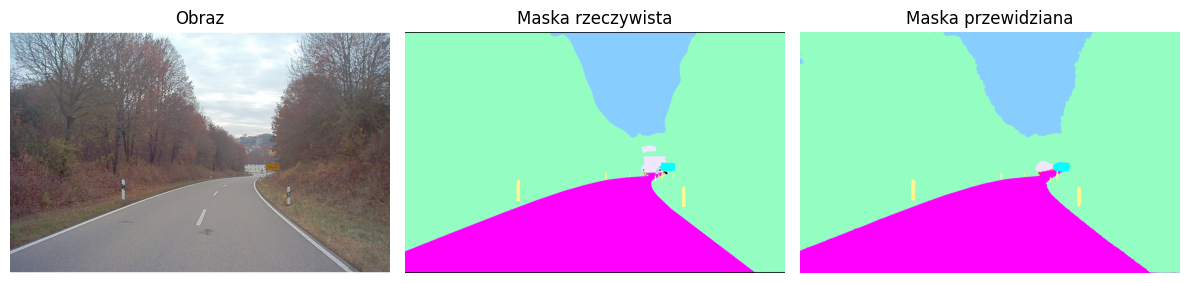

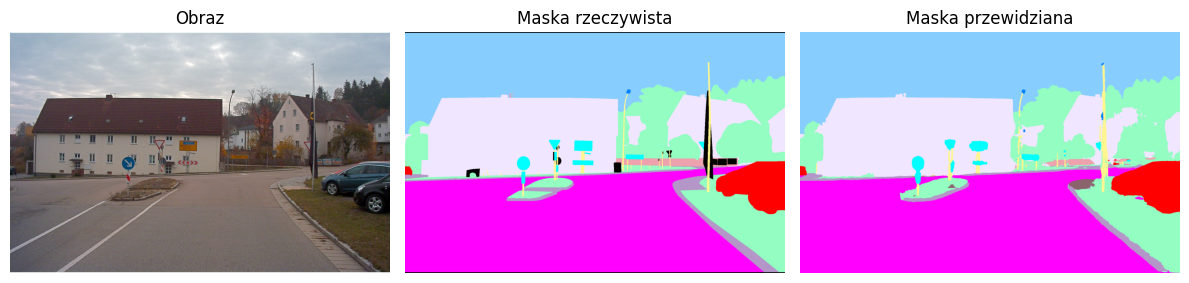

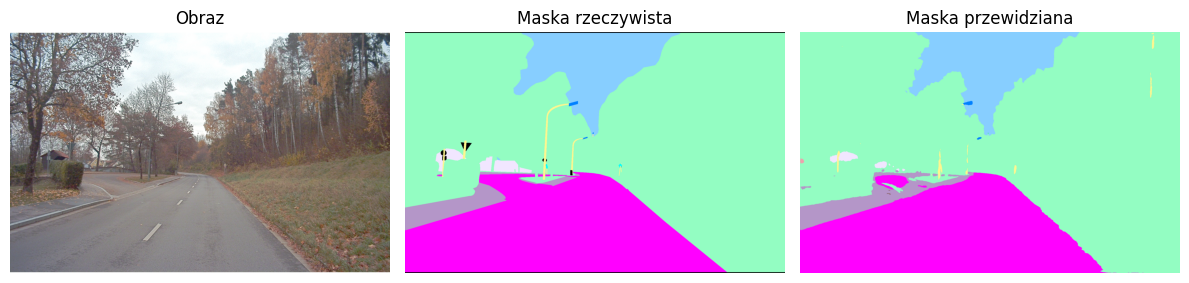

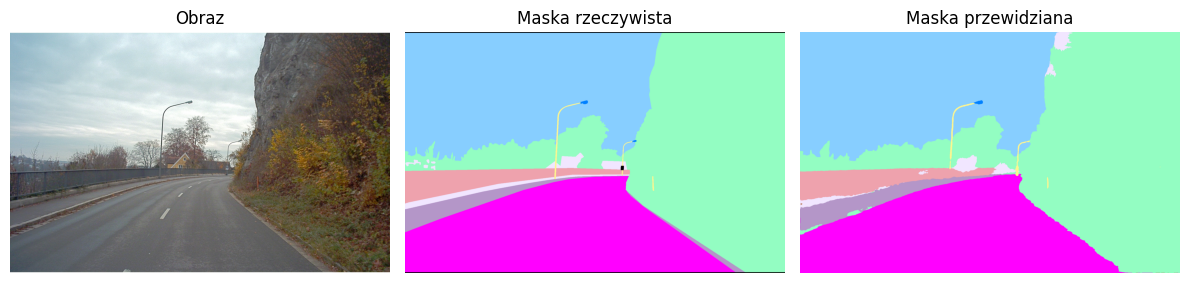

In [12]:
import torch
from utils.image import *

# Cały zbiór walidacyjny

images, masks = next(iter(val_loader))
images = images.to(device)
masks  = masks.to(device)

masks = masks.squeeze(1)

with torch.inference_mode():
    model.eval()
    logits = model(images)

pr_masks = logits.softmax(dim=1).argmax(dim=1)

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx > 4:  # Visualize first 5 samples
        break

    img_cpu  = image.cpu().numpy().transpose(1,2,0)
    gt_cpu   = gt_mask.cpu().numpy()      # (H,W)
    pred_cpu = pr_mask.cpu().numpy()      # (H,W)

    display_image_and_mask(
        image=img_cpu,
        mask_true=gt_cpu,
        mask_pred=pred_cpu,
        mapper=mapper
    )

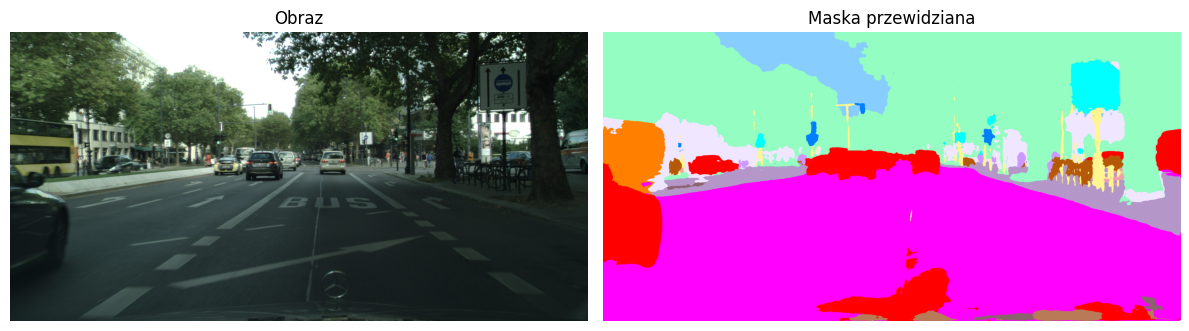

In [13]:
import torch
from torch.utils.data import DataLoader
from utils.image import *

# Custom testowy

test_dataset = Cityscapes(
    root=cityscapes_root,
    split='test',
    target_type="semantic",
    transforms=mapper.wrap_val
)

single_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

# Inference

images, _ = next(iter(single_loader))
images = images.to(device)

with torch.inference_mode():
    logits = model(images)

pr_masks = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=images[0], 
    mask_pred=pr_masks[0], 
    mapper=mapper
)


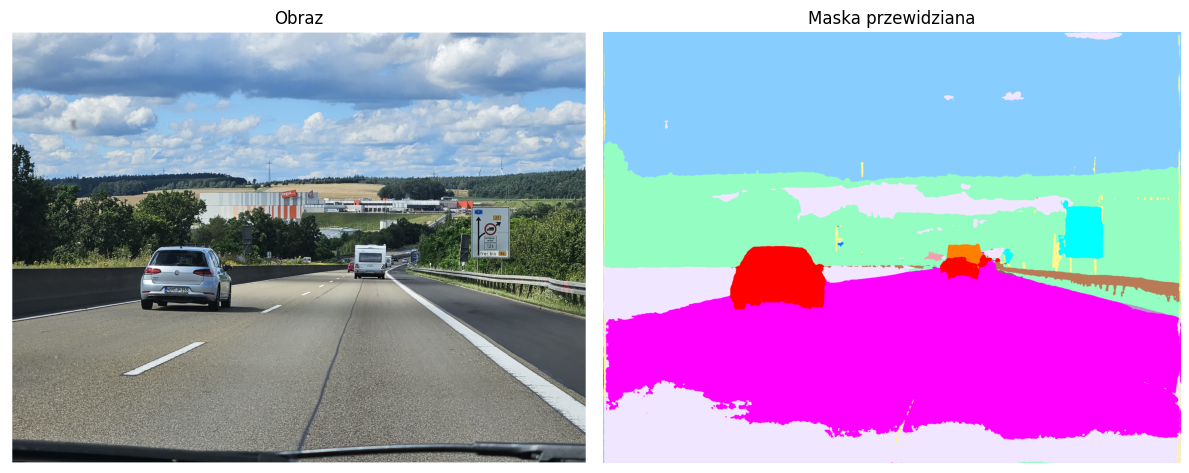

In [14]:
import torch
from PIL import Image
from utils.image import *

# Własny obraz

pil_image = Image.open(r".\test\test2.png").convert("RGB")

aug_image = mapper.preprocess_image(img=np.asarray(pil_image))
tensor_image = aug_image.to(device)

with torch.inference_mode():
    logits = model(tensor_image)
    
pr_mask = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=tensor_image, 
    mask_pred=pr_mask, 
    mapper=mapper
)

## Benchmarkt

In [15]:
import os
from utils.benchmark import start_benchmark

logs_root = ".\\checkpoints\\modern\\stage1\\"

ckpts = find_checkpoints(logs_root)

for ckpt in ckpts.items():
    dir = os.path.dirname(
        os.path.dirname(ckpt[0])
    )
    model = ExperimentalModel.load_from_checkpoint(
        checkpoint_path=ckpt[0],
        mapper=mapper
    )
    print(dir)
    start_benchmark(model)

RuntimeError: Error(s) in loading state_dict for ExperimentalModel:
	size mismatch for model.segmentation_head.0.weight: copying a param with shape torch.Size([20, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([17, 256, 1, 1]).
	size mismatch for model.segmentation_head.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([17]).